In [5]:
import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray
from metloom.pointdata import SnotelPointData, USGSPointData
import seaborn as sns

## To-Do List

- Restrict to 2011-2014
- Restrict to January-April
- Investigate the rolling mean function
- 

In [ ]:
# include area plot 
# places where two notels disagree 
# are there times when one site predicts snow and another predicts rain on snow at one time 
# see what temperature these things happen at 
# future work, make multiclass 
# visual of what rain on snow looks like, what characterizes it 
# plot: one axis has discharge, another has temp
# correlation matrix 
# january 1st through april 1st

In [3]:
pip install metloom

  Using cached metloom-0.6.3-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached geopandas-0.14.4-py3-none-any.whl.metadata (1.5 kB)
  Using cached zeep-4.3.1-py3-none-any.whl.metadata (4.3 kB)
  Using cached isodate-0.7.2-py3-none-any.whl.metadata (11 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached metloom-0.6.3-py2.py3-none-any.whl (56 kB)
Using cached geopandas-0.14.4-py3-none-any.whl (1.1 MB)
Using cached zeep-4.3.1-py3-none-any.whl (101 kB)
Using cached isodate-0.7.2-py3-none-any.whl (22 kB)
Using cached requests_file-2.1.0-py2.py3-none-any.whl (4.2 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packa

In [4]:
pip install pint_xarray

  Using cached pint_xarray-0.4-py3-none-any.whl.metadata (3.2 kB)
  Using cached Pint-0.24.4-py3-none-any.whl.metadata (8.5 kB)
  Using cached flexcache-0.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached flexparser-0.4-py3-none-any.whl.metadata (18 kB)
Using cached pint_xarray-0.4-py3-none-any.whl (32 kB)
Using cached Pint-0.24.4-py3-none-any.whl (302 kB)
Using cached flexcache-0.3-py3-none-any.whl (13 kB)
Using cached flexparser-0.4-py3-none-any.whl (27 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# we will look at january through april 
# predict discharge based on the snotel data
# spike in discharge means rain on snow, we will have 2 classes, so binary classification
# final goal: get a decision tree to predict discharge spikes based on snotel data 
# truth rain from snotel, infer it from discharge


# SWE: snow water equivalent: determines how much water the snowpack contains

### Prediction

#### Predict discharge based on the snotel data

In [6]:
# do some cleaning, we've got some null values 
# null values will be replaced with the mean of the row before and after it

def fill_null(df):
    df = df.copy() 
    df = df.reset_index()
    for col in df.columns:
        print("cleaning ", col)
        null_indices = df[df[col].isnull()].index
        for i in null_indices:
            before = df.loc[i-1, col] if i > 0 else np.nan
            after = df.loc[i+1, col] if i < len(df) - 1 else np.nan

            #Handle cases where either before or after is also NaN
            valid_values = [x for x in [before, after] if pd.notna(x)]
            if valid_values:
              df.loc[i, col] = np.mean(valid_values)
            #If both before and after are NaN, leave the NaN as is

    print(df)
    return df

## Start here with the backfilled data

In [7]:
snotel_hourly = xr.open_dataset('../../data/snotel/snotel_hourly_backfill_1980_2024.zarr')
usgs_hourly = xr.open_dataset('../../data/stream/usgs_instantaneous_backfill_1980_2024.zarr')
usgs_hourly

/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 spec

<xarray.Dataset> Size: 27MB
Dimensions:       (site: 2, date: 1134647)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ... 2024-01-0...
Data variables:
    DISCHARGE     (date, site) float64 18MB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [8]:
# only keep 2019-2024

snotel_month_filtered = snotel_hourly.sel(date=snotel_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))
discharge_month_filtered = usgs_hourly.sel(date=usgs_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))

In [10]:
discharge_month_filtered

<xarray.Dataset> Size: 1MB
Dimensions:       (site: 2, date: 59060)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 472kB 2019-01-01 ... 2024-01-02T07:45:00
Data variables:
    DISCHARGE     (date, site) float64 945kB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [11]:
# line up usgs discharge with their correct sites 

discharge = []
discharge_by_site = discharge_month_filtered.DISCHARGE.values
dishcarge_thunder = discharge_by_site[:,0]
dishcarge_beaver = discharge_by_site[:,1]
for i in range(0,len(dishcarge_thunder)):
    discharge.append(dishcarge_thunder[i])
    discharge.append(dishcarge_beaver[i])

In [13]:
# add discharge to the SNOTEL data 
snotel_hourly_gdf = snotel_month_filtered.to_dataframe().reset_index()
snotel_hourly_numeric = snotel_hourly_gdf.copy()
snotel_hourly_numeric['DISCHARGE'] = discharge
snotel_hourly_numeric


,date,site,ACCUMULATED PRECIPITATION,site_name,SNOWDEPTH,elevation_ft,SWE,lat,AIR TEMP,lon,DISCHARGE
0,2019-01-01 00:00:00,817:WA:SNTL,31.2,Beaver Creek,50.0,4310.0,15.2,48.528,12.56,-120.990,247.0
1,2019-01-01 00:00:00,990:WA:SNTL,35.6,Thunder Basin,56.0,3630.0,16.2,48.879,22.28,-121.256,240.0
2,2019-01-01 00:05:00,817:WA:SNTL,31.2,Beaver Creek,49.0,4310.0,15.2,48.528,10.94,-120.990,249.0
3,2019-01-01 00:05:00,990:WA:SNTL,35.5,Thunder Basin,56.0,3630.0,16.2,48.879,21.38,-121.256,NaN
4,2019-01-01 00:10:00,817:WA:SNTL,31.2,Beaver Creek,49.0,4310.0,15.2,48.528,10.94,-120.990,249.0
...,...,...,...,...,...,...,...,...,...,...,...
118115,2024-01-02 07:15:00,990:WA:SNTL,NaN,Thunder Basin,NaN,3630.0,NaN,48.879,NaN,-121.256,210.0
118116,2024-01-02 07:30:00,817:WA:SNTL,NaN,Beaver Creek,NaN,4310.0,NaN,48.528,NaN,-120.990,220.0
118117,2024-01-02 07:30:00,990:WA:SNTL,NaN,Thunder Basin,NaN,3630.0,NaN,48.879,NaN,-121.256,208.0
118118,2024-01-02 07:45:00,817:WA:SNTL,NaN,Beaver Creek,NaN,4310.0,NaN,48.528,NaN,-120.990,220.0


In [14]:
#grouped_by_site = snotel_hourly_numeric.groupby('site_name')

grouped_by_site = snotel_hourly_numeric.sort_values(['site','date'],ascending=True).groupby('site')
grouped_by_site =grouped_by_site.apply(pd.DataFrame)
grouped_by_site

/tmp/ipykernel_118/3260400871.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_by_site =grouped_by_site.apply(pd.DataFrame)


date         site  \
site                                                  
817:WA:SNTL 0      2019-01-01 00:00:00  817:WA:SNTL   
            2      2019-01-01 00:05:00  817:WA:SNTL   
            4      2019-01-01 00:10:00  817:WA:SNTL   
            6      2019-01-01 00:15:00  817:WA:SNTL   
            8      2019-01-01 00:20:00  817:WA:SNTL   
...                                ...          ...   
990:WA:SNTL 118111 2024-01-02 06:45:00  990:WA:SNTL   
            118113 2024-01-02 07:00:00  990:WA:SNTL   
            118115 2024-01-02 07:15:00  990:WA:SNTL   
            118117 2024-01-02 07:30:00  990:WA:SNTL   
            118119 2024-01-02 07:45:00  990:WA:SNTL   

                    ACCUMULATED PRECIPITATION      site_name  SNOWDEPTH  \
site                                                                      
817:WA:SNTL 0                            31.2   Beaver Creek       50.0   
            2                            31.2   Beaver Creek       49.0   
            4                            31.2   Beaver Creek       49.0   
            6                            31.2   Beaver Creek       49.0   
            8                            31.2   Beaver Creek       49.0   
...                                       ...            ...        ...   
990:WA:SNTL 118111                        NaN  Thunder Basin        NaN   
            118113                        NaN  Thunder Basin        NaN   
            118115                        NaN  Thunder Basin        NaN   
            118117                        NaN  Thunder Basin        NaN   
            118119                        NaN  Thunder Basin        NaN   

                    elevation_ft   SWE     lat  AIR TEMP      lon  DISCHARGE  
site                                                                          
817:WA:SNTL 0             4310.0  15.2  48.528     12.56 -120.990      247.0  
            2             4310.0  15.2  48.528     10.94 -120.990      249.0  
            4             4310.0  15.2  48.528     10.94 -120.990      249.0  
            6             4310.0  15.2  48.528     10.94 -120.990      249.0  
            8             4310.0  15.2  48.528     10.94 -120.990      247.0  
...                          ...   ...     ...       ...      ...        ...  
990:WA:SNTL 118111        3630.0   NaN  48.879       NaN -121.256      208.0  
            118113        3630.0   NaN  48.879       NaN -121.256      210.0  
            118115        3630.0   NaN  48.879       NaN -121.256      210.0  
            118117        3630.0   NaN  48.879       NaN -121.256      208.0  
            118119        3630.0   NaN  48.879       NaN -121.256      208.0  

[118120 rows x 11 columns]

In [17]:
# only keep numeric data 

data_numeric = grouped_by_site.filter(items=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'])

In [18]:
data_numeric

ACCUMULATED PRECIPITATION   SWE  AIR TEMP  DISCHARGE
site                                                                    
817:WA:SNTL 0                            31.2  15.2     12.56      247.0
            2                            31.2  15.2     10.94      249.0
            4                            31.2  15.2     10.94      249.0
            6                            31.2  15.2     10.94      249.0
            8                            31.2  15.2     10.94      247.0
...                                       ...   ...       ...        ...
990:WA:SNTL 118111                        NaN   NaN       NaN      208.0
            118113                        NaN   NaN       NaN      210.0
            118115                        NaN   NaN       NaN      210.0
            118117                        NaN   NaN       NaN      208.0
            118119                        NaN   NaN       NaN      208.0

[118120 rows x 4 columns]

In [19]:
# handle null values in the data

hourly_cleaned = fill_null(data_numeric)

cleaning  site
cleaning  level_1
cleaning  ACCUMULATED PRECIPITATION
cleaning  SWE
cleaning  AIR TEMP
cleaning  DISCHARGE
               site  level_1  ACCUMULATED PRECIPITATION   SWE  AIR TEMP  \
0       817:WA:SNTL        0                       31.2  15.2     12.56   
1       817:WA:SNTL        2                       31.2  15.2     10.94   
2       817:WA:SNTL        4                       31.2  15.2     10.94   
3       817:WA:SNTL        6                       31.2  15.2     10.94   
4       817:WA:SNTL        8                       31.2  15.2     10.94   
...             ...      ...                        ...   ...       ...   
118115  990:WA:SNTL   118111                       24.1   6.3     30.20   
118116  990:WA:SNTL   118113                       24.1   6.3     30.20   
118117  990:WA:SNTL   118115                       24.1   6.3     30.20   
118118  990:WA:SNTL   118117                       24.1   6.3     30.20   
118119  990:WA:SNTL   118119                       24

In [15]:
# get rid of the level_1 column that was added 

hourly_cleaned = hourly_cleaned.drop("level_1", axis =1)

In [16]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE
0,817:WA:SNTL,31.2,15.2,12.56,247.0
1,817:WA:SNTL,31.2,15.2,10.94,249.0
2,817:WA:SNTL,31.2,15.2,10.94,249.0
3,817:WA:SNTL,31.2,15.2,10.94,249.0
4,817:WA:SNTL,31.2,15.2,10.94,247.0
...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0
118116,990:WA:SNTL,24.1,6.3,30.20,210.0
118117,990:WA:SNTL,24.1,6.3,30.20,210.0
118118,990:WA:SNTL,24.1,6.3,30.20,208.0


### Classification
#### Fit a model based on air temp, SWE, and snow_depth to predict discharge 

In [22]:
# set grounds truths

# Snow or Rain on Snow: binary classification
# 0: Snow 
# 1: Rain on Snow 

### We will start with a basic rolling mean classification....

In [23]:
def rolling_stats(data,var):
    # Calculate the rolling median and standard deviation
    rolling_median = data[var].rolling(window=24, center=True, min_periods=1).median()
    rolling_std = data[var].rolling(window=24, center=True, min_periods=1).std()

    return [rolling_median, rolling_std]

In [121]:
def assign_labels(data, var, air_temp = False):
    mu = rolling_stats(data,var)[0]
    sigma = rolling_stats(data,var)[1]

    truths = []
    mask = data[var] > mu+(sigma/2)
    truths = mask

    return truths

In [122]:
ground_truths = assign_labels(hourly_cleaned, 'DISCHARGE', air_temp = False)

## Correlation Matrix

<Axes: >

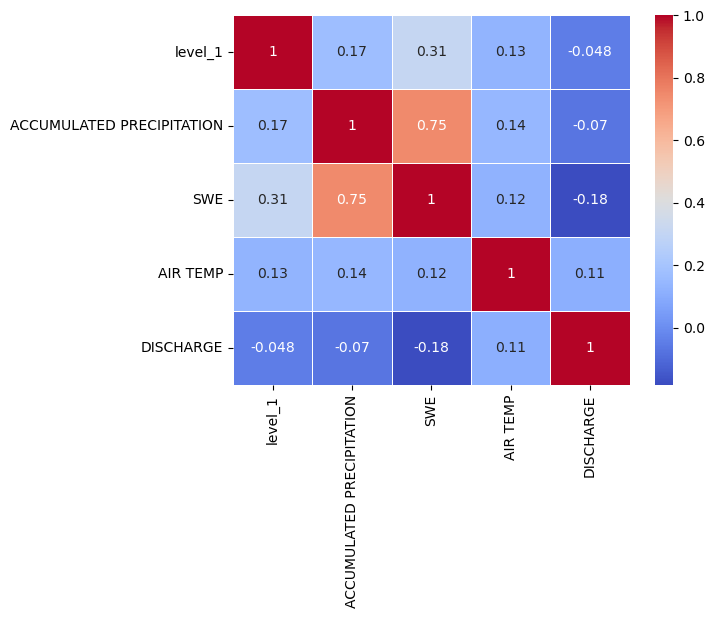

In [103]:
data_corr_matrix = hourly_cleaned.drop('site', axis=1).corr()
sns.heatmap(data_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)

## Decision Tree Regression 
#### Predict float discharge values

In [123]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [124]:

X_data = hourly_cleaned.drop(['site', 'DISCHARGE', 'level_1'], axis =1)
X_data = X_data.to_numpy()

In [125]:
hourly_cleaned

,site,level_1,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE
0,817:WA:SNTL,0,31.2,15.2,12.56,247.0
1,817:WA:SNTL,2,31.2,15.2,10.94,249.0
2,817:WA:SNTL,4,31.2,15.2,10.94,249.0
3,817:WA:SNTL,6,31.2,15.2,10.94,249.0
4,817:WA:SNTL,8,31.2,15.2,10.94,247.0
...,...,...,...,...,...,...
118115,990:WA:SNTL,118111,24.1,6.3,30.20,208.0
118116,990:WA:SNTL,118113,24.1,6.3,30.20,210.0
118117,990:WA:SNTL,118115,24.1,6.3,30.20,210.0
118118,990:WA:SNTL,118117,24.1,6.3,30.20,208.0


In [126]:
X_data

array([[31.2 , 15.2 , 12.56],
       [31.2 , 15.2 , 10.94],
       [31.2 , 15.2 , 10.94],
       ...,
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ]])

In [127]:
def run_regr(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clfr = tree.DecisionTreeRegressor(max_depth = max_depth)
    clfr.fit(X_train, y_train)
    score = clfr.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clfr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [128]:
accs = []
for i in range(1,21):
    accs.append(run_regr(X_data,hourly_cleaned['DISCHARGE'], i))

Test Score: 0.1152
Mean Squared Error: 27439.1726
Test Score: 0.1517
Mean Squared Error: 28499.4629
Test Score: 0.2132
Mean Squared Error: 25215.4322
Test Score: 0.3804
Mean Squared Error: 20181.4484
Test Score: 0.3740
Mean Squared Error: 22492.7338
Test Score: 0.5623
Mean Squared Error: 14983.8356
Test Score: 0.8093
Mean Squared Error: 6327.5249
Test Score: 0.8520
Mean Squared Error: 5067.3747
Test Score: 0.8936
Mean Squared Error: 3859.2945
Test Score: 0.9374
Mean Squared Error: 2045.7835
Test Score: 0.9432
Mean Squared Error: 1882.0852
Test Score: 0.9588
Mean Squared Error: 1364.8969
Test Score: 0.9707
Mean Squared Error: 940.4177
Test Score: 0.9888
Mean Squared Error: 356.1565
Test Score: 0.9947
Mean Squared Error: 176.3081
Test Score: 0.9939
Mean Squared Error: 206.1052
Test Score: 0.9934
Mean Squared Error: 206.6671
Test Score: 0.9950
Mean Squared Error: 168.3135
Test Score: 0.9863
Mean Squared Error: 484.7613
Test Score: 0.9952
Mean Squared Error: 166.6771


Text(0, 0.5, 'Test Accuracy')

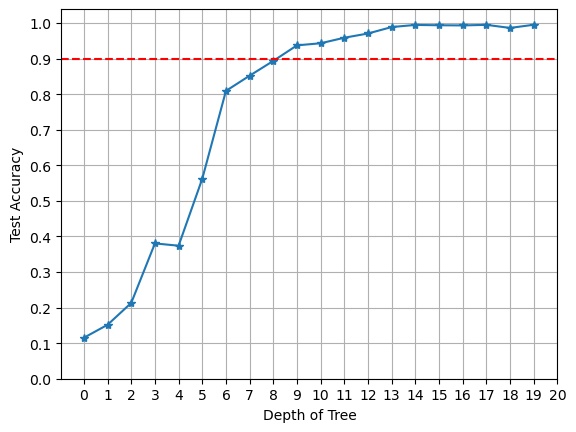

In [129]:
plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

In [111]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = X_data
y = hourly_cleaned['DISCHARGE']

# i'll do 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
clfr = tree.DecisionTreeRegressor(max_depth = 10)
clfr.fit(X_train, y_train)
clfr.score(X_test, y_test)

0.9400258358699375

In [112]:
y_pred = clfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1924.3842


In [113]:
clfr.get_depth()

10

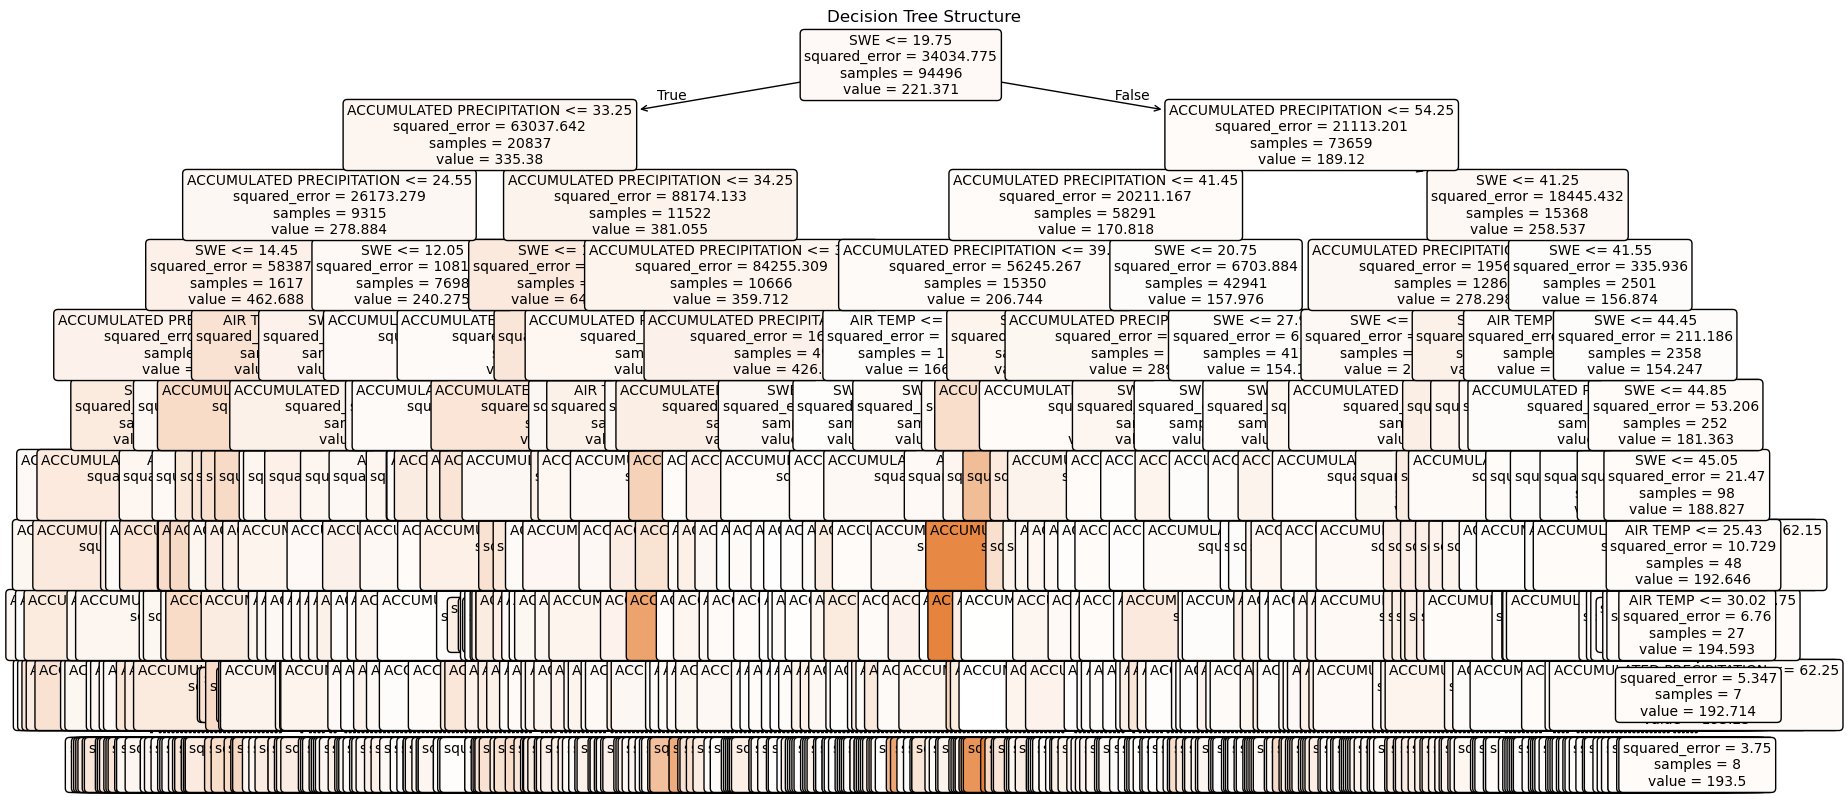

In [114]:
from sklearn.tree import plot_tree

# Visualizing decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    clfr,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()


In [115]:
y_1 = clfr.predict(X_test)
len(y_1)

23624

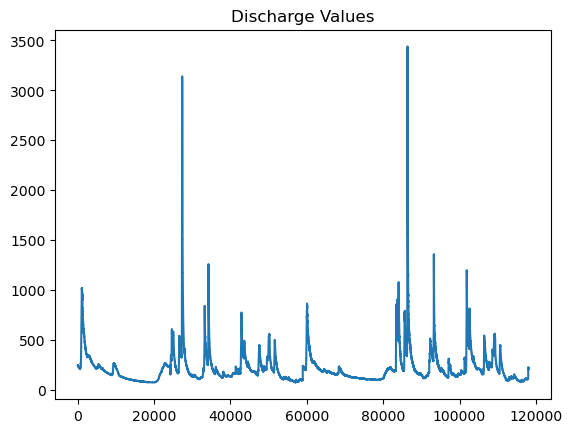

In [116]:
plt.title("Discharge Values")
plt.plot(y)

## Want to visualize the data with the regression line here 



## Decision Tree Classification

#### Predicts integer values 0 (snow)or 1 (rain on snow)

In [117]:
hourly_cleaned

,site,level_1,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE
0,817:WA:SNTL,0,31.2,15.2,12.56,247.0
1,817:WA:SNTL,2,31.2,15.2,10.94,249.0
2,817:WA:SNTL,4,31.2,15.2,10.94,249.0
3,817:WA:SNTL,6,31.2,15.2,10.94,249.0
4,817:WA:SNTL,8,31.2,15.2,10.94,247.0
...,...,...,...,...,...,...
118115,990:WA:SNTL,118111,24.1,6.3,30.20,208.0
118116,990:WA:SNTL,118113,24.1,6.3,30.20,210.0
118117,990:WA:SNTL,118115,24.1,6.3,30.20,210.0
118118,990:WA:SNTL,118117,24.1,6.3,30.20,208.0


In [118]:
# will use sklearn's decision tree for now....

from sklearn import tree
X_data_class = hourly_cleaned.drop(["site", "level_1"], axis =1).to_numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X_data_class, ground_truths.to_numpy().tolist(), test_size=0.20)

clf = tree.DecisionTreeClassifier(max_depth = 5)

# y_train_labels will be a vector of 0s and 1s from the ground_truths 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [119]:
clf.score(X_test, y_test)

0.9098374534371825

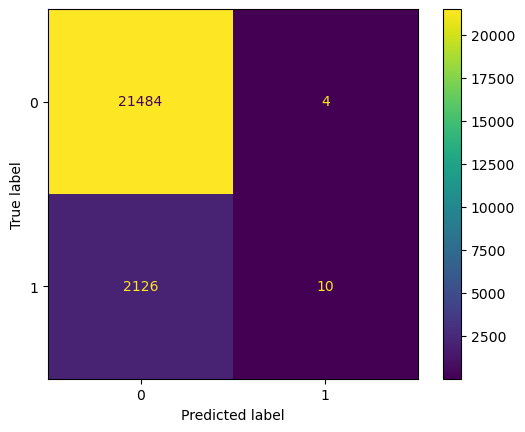

In [120]:
# add confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_true = y_test
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


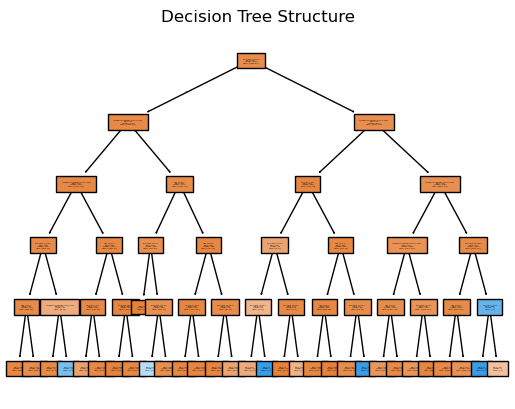

In [124]:
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=1
)
plt.title("Decision Tree Structure")
plt.show()

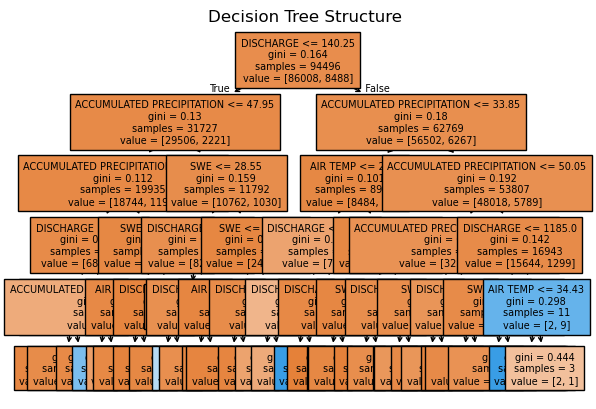

In [125]:
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=7
)
plt.title("Decision Tree Structure")
plt.show()

In [ ]:
plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

## Tree Pruning

In [126]:
def run_class(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [129]:
accs = []
for i in range(1,21):
    accs.append(run_class(X_data_class, ground_truths.to_numpy().tolist(), i))

Test Score: 0.9126
Mean Squared Error: 0.0874
Test Score: 0.9123
Mean Squared Error: 0.0877
Test Score: 0.9104
Mean Squared Error: 0.0896
Test Score: 0.9118
Mean Squared Error: 0.0882
Test Score: 0.9125
Mean Squared Error: 0.0875
Test Score: 0.9123
Mean Squared Error: 0.0877
Test Score: 0.9092
Mean Squared Error: 0.0908
Test Score: 0.9103
Mean Squared Error: 0.0897
Test Score: 0.9122
Mean Squared Error: 0.0878
Test Score: 0.9138
Mean Squared Error: 0.0862
Test Score: 0.9112
Mean Squared Error: 0.0888
Test Score: 0.9109
Mean Squared Error: 0.0891
Test Score: 0.9111
Mean Squared Error: 0.0889
Test Score: 0.9067
Mean Squared Error: 0.0933
Test Score: 0.9073
Mean Squared Error: 0.0927
Test Score: 0.9070
Mean Squared Error: 0.0930
Test Score: 0.9062
Mean Squared Error: 0.0938
Test Score: 0.9068
Mean Squared Error: 0.0932
Test Score: 0.9070
Mean Squared Error: 0.0930
Test Score: 0.9042
Mean Squared Error: 0.0958


Text(0.5, 1.0, 'Example of possible overfitting')

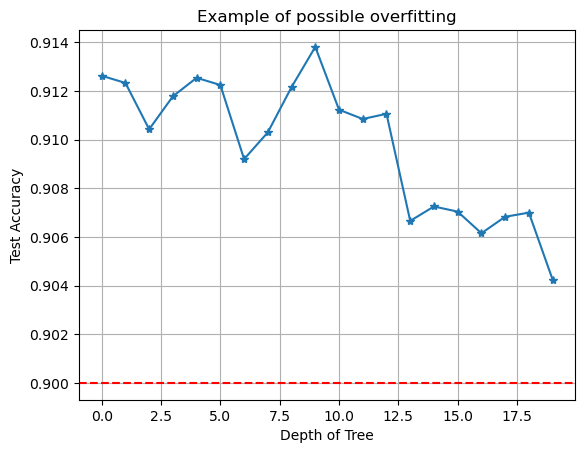

In [137]:
plt.plot(accs, '-*')
plt.grid()
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")
plt.title("Example of possible overfitting")

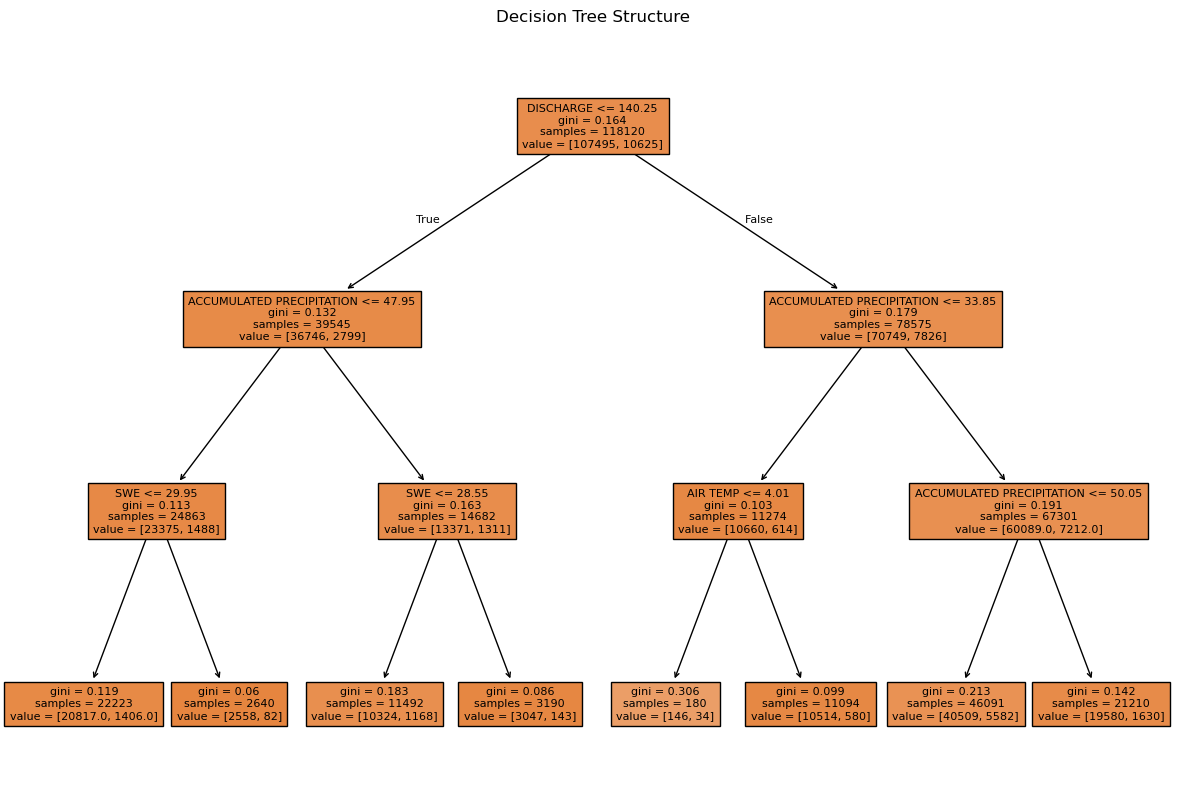

In [141]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(X_data_class, ground_truths.to_numpy().tolist())
plt.figure(figsize=(15, 10))
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=8
)
plt.title("Decision Tree Structure")
plt.show()

### Do some more thorough pruning

In [ ]:
## TODO